# Sheet Music Matching with Optimization

## Project Goal
Learn optimal feature weights to match sheet music pages using constrained optimization techniques.

## Approach
- **Dataset**: Start with music21's built-in Bach chorales as our test corpus
- **Method**: Weighted similarity learning with convex optimization
- **Tools**: Use cvxpy for constrained optimization to learn feature weights that maximize matching accuracy

## Key Components
1. Extract musical features from sheet music (pitch, rhythm, harmony)
2. Define a weighted similarity function
3. Use optimization to learn weights that best distinguish matching vs. non-matching pages
4. Validate performance on held-out test set

## Setup: Install and Import Libraries

In [5]:
# Install required packages
%pip install music21 numpy pandas matplotlib seaborn scipy cvxpy

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Import libraries
import music21 as m21
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize
import cvxpy as cp

# Configure visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("All libraries imported successfully!")
print(f"music21 version: {m21.VERSION_STR}")

All libraries imported successfully!
music21 version: 9.9.1


## Verify Access to Bach Chorale Corpus

Check that we can access music21's built-in corpus of Bach chorales, which we'll use for developing and testing our optimization-based matching algorithm.

In [7]:
# List available Bach chorales in the music21 corpus
bach_chorales = m21.corpus.search('bach', 'composer')

print(f"Total Bach chorales available: {len(bach_chorales)}")
print("\nFirst 10 chorales:")
for i, chorale in enumerate(bach_chorales[:10], 1):
    print(f"{i}. {chorale.metadata.title if chorale.metadata else 'Untitled'} - {chorale.sourcePath}")

# Load a sample chorale to verify everything works
print("\n" + "="*60)
print("Loading a sample chorale to verify corpus access...")
sample_chorale = m21.corpus.parse('bach/bwv66.6')
print(f"✓ Successfully loaded: {sample_chorale.metadata.title}")
print(f"  - Parts: {len(sample_chorale.parts)}")
print(f"  - Measures: {len(sample_chorale.parts[0].getElementsByClass('Measure'))}")
print(f"  - Key: {sample_chorale.analyze('key')}")

Total Bach chorales available: 363

First 10 chorales:
1. None - bach/bwv10.7.mxl
2. None - bach/bwv101.7.mxl
3. None - bach/bwv102.7.mxl
4. None - bach/bwv103.6.mxl
5. None - bach/bwv104.6.mxl
6. None - bach/bwv108.6.mxl
7. None - bach/bwv11.6.mxl
8. None - bach/bwv110.7.mxl
9. None - bach/bwv112.5-sc.mxl
10. None - bach/bwv113.8.mxl

Loading a sample chorale to verify corpus access...
✓ Successfully loaded: None
  - Parts: 4
  - Measures: 10
  - Key: f# minor


## Data Selection and Preparation

Select a subset of Bach chorales and split them into "pages" (chunks of 8 consecutive measures) for our matching experiment.

In [8]:
# Configuration
TARGET_CHORALES = 7  # Try to get 5-7 chorales that meet our criteria
MEASURES_PER_PAGE = 8
TARGET_PAGES_PER_CHORALE = 4
TARGET_MEASURES = MEASURES_PER_PAGE * TARGET_PAGES_PER_CHORALE  # 32 measures

print("Step 1: Finding Bach chorales with at least 32 measures")
print("=" * 80)

# Get all Bach chorales from corpus
all_bach_paths = m21.corpus.getComposer('bach')

# Filter chorales that have >= 32 measures
eligible_chorales = []
failed_chorales = []

for path in all_bach_paths:
    try:
        # Load the score
        score = m21.corpus.parse(path)
        
        # Get first part and count measures
        if len(score.parts) > 0:
            measures = score.parts[0].getElementsByClass(m21.stream.Measure)
            num_measures = len(measures)
            
            if num_measures >= TARGET_MEASURES:
                # Extract metadata
                title = score.metadata.title if score.metadata and score.metadata.title else "Unknown"
                eligible_chorales.append({
                    'path': path,
                    'num_measures': num_measures,
                    'title': title
                })
                
    except Exception as e:
        failed_chorales.append({'path': path, 'error': str(e)})

print(f"✓ Found {len(eligible_chorales)} chorales with >= {TARGET_MEASURES} measures")
if failed_chorales:
    print(f"⚠ Skipped {len(failed_chorales)} chorales due to parsing errors")

# Select the first TARGET_CHORALES eligible chorales
selected_chorales_info = eligible_chorales[:TARGET_CHORALES]

print(f"\nStep 2: Loading {len(selected_chorales_info)} chorales")
print("=" * 80)

# Load each chorale and extract metadata
chorales_data = {}

for chorale_info in selected_chorales_info:
    chorale_path = chorale_info['path']
    
    # Extract simple ID from path (e.g., 'bwv66.6' from 'bach/bwv66.6')
    # chorale_path is a PosixPath object, so use .name to get the filename
    chorale_id = chorale_path.name if hasattr(chorale_path, 'name') else str(chorale_path).split('/')[-1]
    
    # Load the score
    score = m21.corpus.parse(chorale_path)
    
    # Extract metadata
    title = score.metadata.title if score.metadata and score.metadata.title else "Unknown"
    
    # Get key (handle potential errors)
    try:
        key = score.analyze('key')
    except:
        key = "Unknown"
    
    # Get time signature from first part
    time_sig = None
    for ts in score.flat.getElementsByClass(m21.meter.TimeSignature):
        time_sig = ts
        break
    time_sig_str = str(time_sig) if time_sig else "Unknown"
    
    # Count measures (use first part as reference)
    measures = score.parts[0].getElementsByClass(m21.stream.Measure)
    num_measures = len(measures)
    
    # Store the data
    chorales_data[chorale_id] = {
        'score': score,
        'title': title,
        'key': str(key),
        'time_signature': time_sig_str,
        'num_measures': num_measures
    }
    
    # Print metadata
    print(f"\n{chorale_id}")
    print(f"  Title: {title}")
    print(f"  Key: {key}")
    print(f"  Time Signature: {time_sig_str}")
    print(f"  Measures: {num_measures} ✓ (>= {TARGET_MEASURES} required)")
    print(f"  Parts: {len(score.parts)}")

print("\n" + "=" * 80)
print(f"Successfully loaded {len(chorales_data)} chorales, each with >= {TARGET_MEASURES} measures")


Step 1: Finding Bach chorales with at least 32 measures
✓ Found 22 chorales with >= 32 measures

Step 2: Loading 7 chorales

bwv17.7.mxl
  Title: Unknown
  Key: A major
  Time Signature: <music21.meter.TimeSignature 3/4>
  Measures: 42 ✓ (>= 32 required)
  Parts: 4

bwv171.6.mxl
  Title: Unknown
  Key: D major
  Time Signature: <music21.meter.TimeSignature 4/4>
  Measures: 48 ✓ (>= 32 required)
  Parts: 8

bwv190.7-inst.mxl
  Title: Unknown
  Key: D major
  Time Signature: <music21.meter.TimeSignature 4/4>
  Measures: 33 ✓ (>= 32 required)
  Parts: 15


/Users/ethanfan/Documents/Penn/stat4830/.venv/lib/python3.13/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)



bwv190.7.mxl
  Title: Unknown
  Key: D major
  Time Signature: <music21.meter.TimeSignature 4/4>
  Measures: 33 ✓ (>= 32 required)
  Parts: 4

bwv248.42-4.mxl
  Title: Unknown
  Key: F major
  Time Signature: <music21.meter.TimeSignature 3/4>
  Measures: 53 ✓ (>= 32 required)
  Parts: 12

bwv248.64-6.mxl
  Title: Unknown
  Key: D major
  Time Signature: <music21.meter.TimeSignature 4/4>
  Measures: 69 ✓ (>= 32 required)
  Parts: 14

bwv276.mxl
  Title: Unknown
  Key: d minor
  Time Signature: <music21.meter.TimeSignature 4/4>
  Measures: 32 ✓ (>= 32 required)
  Parts: 4

Successfully loaded 7 chorales, each with >= 32 measures


### Split Chorales into Pages

Define a "page" as 8 consecutive measures. Split each chorale into pages for the matching experiment.

In [9]:
# Create pages from chorales - STRICT MODE
# Each chorale MUST produce exactly 4 pages of 8 measures each
pages_list = []

print("Creating pages from chorales (STRICT MODE):")
print("=" * 80)
print(f"Configuration: {MEASURES_PER_PAGE} measures/page, {TARGET_PAGES_PER_CHORALE} pages/chorale")
print()

for chorale_id, data in chorales_data.items():
    score = data['score']
    num_measures = data['num_measures']
    
    # Use first part as reference for splitting
    part = score.parts[0]
    measures = list(part.getElementsByClass(m21.stream.Measure))
    
    print(f"{chorale_id}: {num_measures} measures", end="")
    
    # Verify we have enough measures (should always be true due to filtering)
    if num_measures < TARGET_MEASURES:
        print(f" ✗ SKIPPED (need {TARGET_MEASURES})")
        continue
    
    print(f" → Creating {TARGET_PAGES_PER_CHORALE} pages")
    
    # Create exactly 4 pages, using only the first 32 measures
    for page_idx in range(TARGET_PAGES_PER_CHORALE):
        start_idx = page_idx * MEASURES_PER_PAGE
        end_idx = start_idx + MEASURES_PER_PAGE
        
        # Extract exactly 8 consecutive measures
        page_measures = measures[start_idx:end_idx]
        
        # Verify we got exactly 8 measures
        if len(page_measures) != MEASURES_PER_PAGE:
            print(f"  ✗ Page {page_idx}: ERROR - got {len(page_measures)} measures instead of {MEASURES_PER_PAGE}")
            continue
        
        # Get measure numbers (they might not start at 1)
        measure_numbers = [m.number for m in page_measures]
        start_measure_num = measure_numbers[0]
        end_measure_num = measure_numbers[-1]
        
        # Create page data
        page_data = {
            'page_id': f"{chorale_id}_page{page_idx}",
            'chorale_id': chorale_id,
            'page_index': page_idx,
            'measures': page_measures,  # Store actual measure objects
            'start_measure': start_measure_num,
            'end_measure': end_measure_num,
            'num_measures': len(page_measures)
        }
        
        pages_list.append(page_data)
        print(f"  ✓ Page {page_idx}: measures {start_measure_num}-{end_measure_num} (indices {start_idx}-{end_idx-1})")

print("\n" + "=" * 80)
print(f"Successfully created {len(pages_list)} pages from {len(chorales_data)} chorales")
print(f"Expected: {len(chorales_data) * TARGET_PAGES_PER_CHORALE} pages")
print(f"Status: {'✓ SUCCESS' if len(pages_list) == len(chorales_data) * TARGET_PAGES_PER_CHORALE else '✗ MISMATCH'}")

# Verify each chorale produced exactly 4 pages
print("\nVerification - Pages per Chorale:")
for chorale_id in chorales_data.keys():
    count = sum(1 for p in pages_list if p['chorale_id'] == chorale_id)
    status = "✓" if count == TARGET_PAGES_PER_CHORALE else "✗"
    print(f"  {status} {chorale_id}: {count} pages")


Creating pages from chorales (STRICT MODE):
Configuration: 8 measures/page, 4 pages/chorale

bwv17.7.mxl: 42 measures → Creating 4 pages
  ✓ Page 0: measures 0-7 (indices 0-7)
  ✓ Page 1: measures 8-14 (indices 8-15)
  ✓ Page 2: measures 15-21 (indices 16-23)
  ✓ Page 3: measures 22-28 (indices 24-31)
bwv171.6.mxl: 48 measures → Creating 4 pages
  ✓ Page 0: measures 0-7 (indices 0-7)
  ✓ Page 1: measures 8-15 (indices 8-15)
  ✓ Page 2: measures 16-23 (indices 16-23)
  ✓ Page 3: measures 24-30 (indices 24-31)
bwv190.7-inst.mxl: 33 measures → Creating 4 pages
  ✓ Page 0: measures 0-7 (indices 0-7)
  ✓ Page 1: measures 8-15 (indices 8-15)
  ✓ Page 2: measures 16-23 (indices 16-23)
  ✓ Page 3: measures 24-31 (indices 24-31)
bwv190.7.mxl: 33 measures → Creating 4 pages
  ✓ Page 0: measures 0-7 (indices 0-7)
  ✓ Page 1: measures 8-15 (indices 8-15)
  ✓ Page 2: measures 16-23 (indices 16-23)
  ✓ Page 3: measures 24-31 (indices 24-31)
bwv248.42-4.mxl: 53 measures → Creating 4 pages
  ✓ Page 0:

### Create DataFrame for Pages

Store all page data in a pandas DataFrame for easy access and manipulation.

In [10]:
# Create DataFrame with page data
# Note: We'll store measure objects separately to avoid serialization issues
pages_df = pd.DataFrame([
    {
        'page_id': p['page_id'],
        'chorale_id': p['chorale_id'],
        'page_index': p['page_index'],
        'start_measure': p['start_measure'],
        'end_measure': p['end_measure'],
        'num_measures': p['num_measures']
    }
    for p in pages_list
])

# Store measure objects in a separate dictionary for easy lookup
pages_measures = {p['page_id']: p['measures'] for p in pages_list}

print("Pages DataFrame:")
print("=" * 80)
print(pages_df)
print("\n" + "=" * 80)
print(f"Shape: {pages_df.shape[0]} pages × {pages_df.shape[1]} columns")

Pages DataFrame:
                    page_id         chorale_id  page_index  start_measure  \
0         bwv17.7.mxl_page0        bwv17.7.mxl           0              0   
1         bwv17.7.mxl_page1        bwv17.7.mxl           1              8   
2         bwv17.7.mxl_page2        bwv17.7.mxl           2             15   
3         bwv17.7.mxl_page3        bwv17.7.mxl           3             22   
4        bwv171.6.mxl_page0       bwv171.6.mxl           0              0   
5        bwv171.6.mxl_page1       bwv171.6.mxl           1              8   
6        bwv171.6.mxl_page2       bwv171.6.mxl           2             16   
7        bwv171.6.mxl_page3       bwv171.6.mxl           3             24   
8   bwv190.7-inst.mxl_page0  bwv190.7-inst.mxl           0              0   
9   bwv190.7-inst.mxl_page1  bwv190.7-inst.mxl           1              8   
10  bwv190.7-inst.mxl_page2  bwv190.7-inst.mxl           2             16   
11  bwv190.7-inst.mxl_page3  bwv190.7-inst.mxl           3 

### Summary Visualization

Display a summary table showing how many pages each chorale produced.

Summary: Pages per Chorale
       Chorale ID   Title  Total Measures  Pages Created  Measures Used
      bwv17.7.mxl Unknown              42              4             32
     bwv171.6.mxl Unknown              48              4             32
bwv190.7-inst.mxl Unknown              33              4             32
     bwv190.7.mxl Unknown              33              4             32
  bwv248.42-4.mxl Unknown              53              4             32
  bwv248.64-6.mxl Unknown              69              4             32
       bwv276.mxl Unknown              32              4             32

Total Pages: 28
Total Chorales: 7
Average Pages per Chorale: 4.0


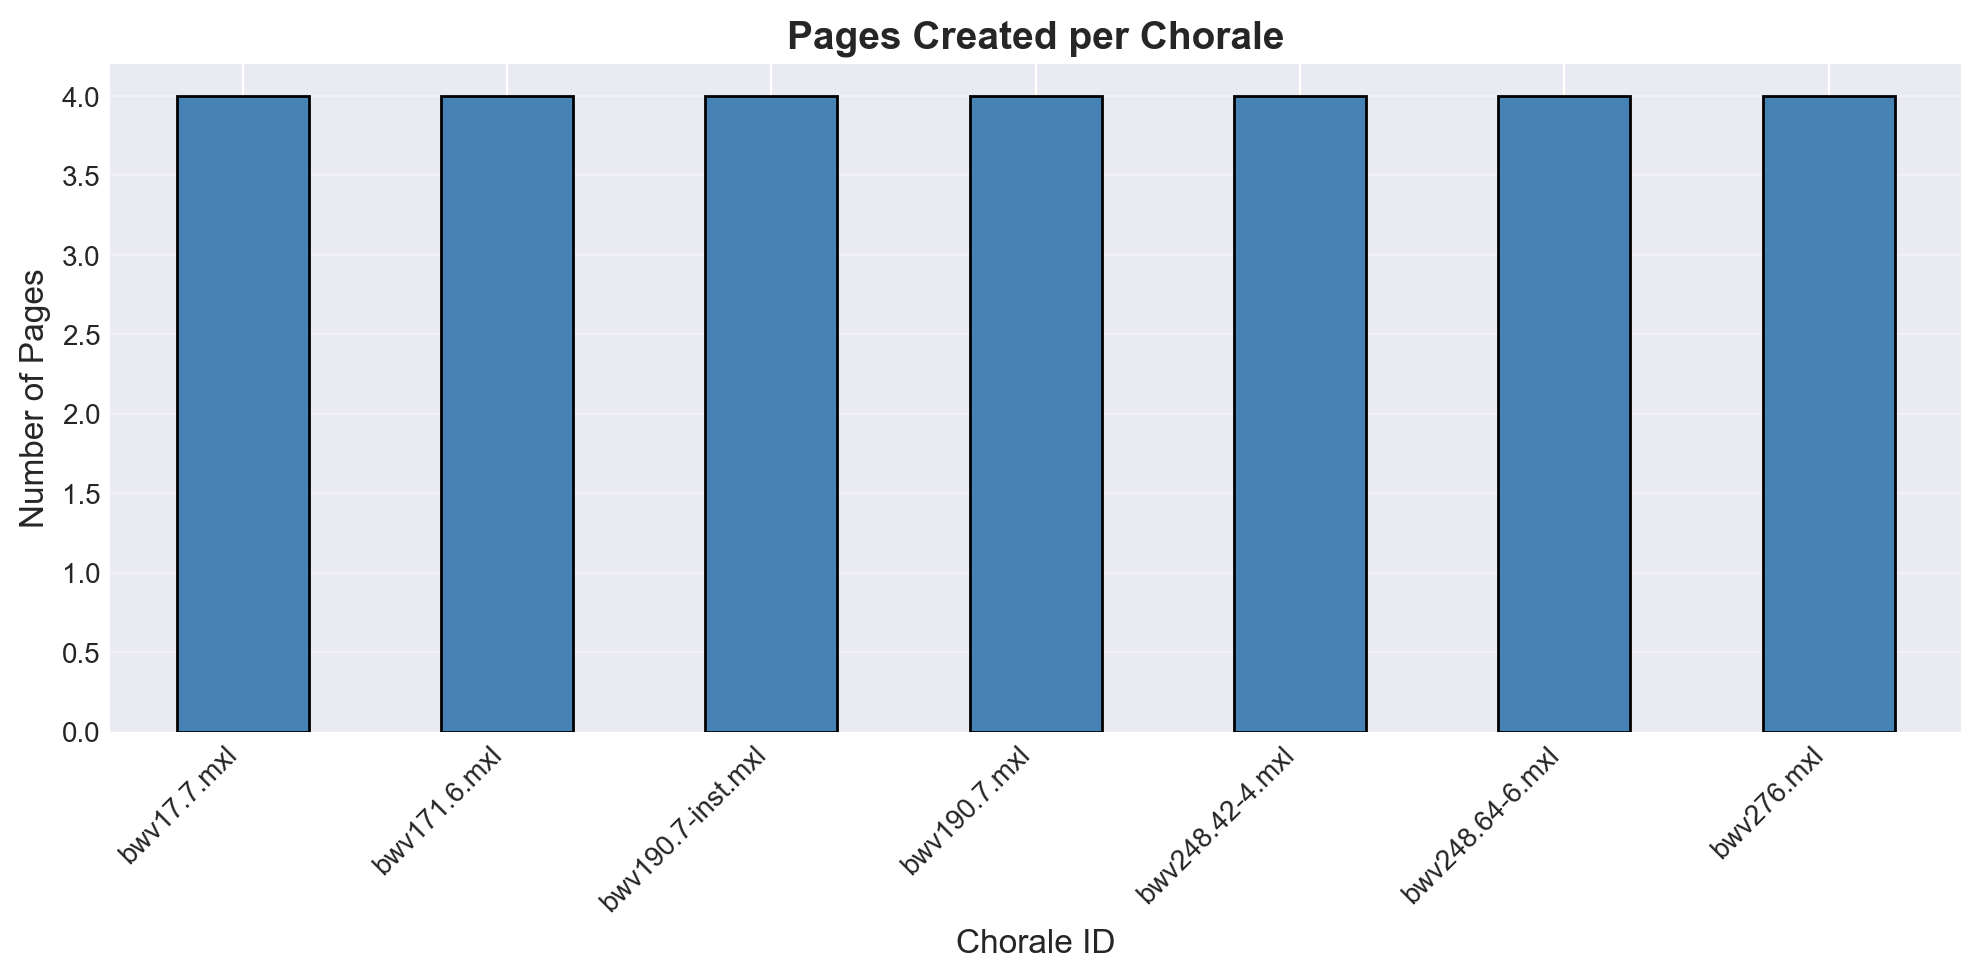


✓ Data preparation complete!


In [11]:
# Create summary statistics
summary_data = []

for chorale_id in chorales_data.keys():
    num_pages = len(pages_df[pages_df['chorale_id'] == chorale_id])
    num_measures = chorales_data[chorale_id]['num_measures']
    title = chorales_data[chorale_id]['title']
    
    summary_data.append({
        'Chorale ID': chorale_id,
        'Title': title[:40] + '...' if len(title) > 40 else title,
        'Total Measures': num_measures,
        'Pages Created': num_pages,
        'Measures Used': num_pages * MEASURES_PER_PAGE
    })

summary_df = pd.DataFrame(summary_data)

print("Summary: Pages per Chorale")
print("=" * 80)
print(summary_df.to_string(index=False))
print("\n" + "=" * 80)
print(f"Total Pages: {pages_df.shape[0]}")
print(f"Total Chorales: {len(chorales_data)}")
print(f"Average Pages per Chorale: {pages_df.shape[0] / len(chorales_data):.1f}")

# Visualize distribution
fig, ax = plt.subplots(figsize=(10, 5))
pages_per_chorale = pages_df['chorale_id'].value_counts().sort_index()
pages_per_chorale.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Chorale ID', fontsize=12)
ax.set_ylabel('Number of Pages', fontsize=12)
ax.set_title('Pages Created per Chorale', fontsize=14, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Data preparation complete!")

## Feature Extraction

Extract 5 musical features from each page for use in the optimization-based matching algorithm:

1. **key_numeric**: Key signature encoded as integer (0-11.5)
2. **time_signature_ratio**: Time signature as decimal (e.g., 3/4 = 0.75)
3. **average_pitch**: Mean MIDI pitch number from soprano voice
4. **pitch_range**: Range of pitches (max - min)
5. **note_density**: Notes per beat (rhythmic activity measure)

In [12]:
def extract_features_from_page(page_id, measures):
    """
    Extract 5 musical features from a page (chunk of measures).
    
    Args:
        page_id: Unique identifier for the page
        measures: List of music21 Measure objects
        
    Returns:
        Dictionary with extracted features
    """
    features = {
        'page_id': page_id,
        'key_numeric': 0.0,
        'time_signature_ratio': 1.0,
        'average_pitch': 0.0,
        'pitch_range': 0.0,
        'note_density': 0.0
    }
    
    try:
        # Reconstruct a stream from the measures for analysis
        page_stream = m21.stream.Part()
        for measure in measures:
            page_stream.append(measure)
        
        # ===== Feature 1: key_numeric =====
        try:
            key = page_stream.analyze('key')
            # Map pitch class: C=0, C#=1, D=2, ..., B=11
            tonic = key.tonic
            pitch_class = tonic.pitchClass  # 0-11
            # Add 0.5 for minor keys
            mode_offset = 0.0 if key.mode == 'major' else 0.5
            features['key_numeric'] = pitch_class + mode_offset
        except Exception as e:
            # Default to 0 (C major) if analysis fails
            features['key_numeric'] = 0.0
            print(f"⚠ Warning: Key analysis failed for {page_id}: {e}")
        
        # ===== Feature 2: time_signature_ratio =====
        try:
            time_sigs = page_stream.flatten().getElementsByClass(m21.meter.TimeSignature)
            if time_sigs:
                ts = time_sigs[0]  # Use first time signature
                # Convert to ratio (e.g., 3/4 = 0.75, 4/4 = 1.0)
                features['time_signature_ratio'] = ts.numerator / ts.denominator
            else:
                # Default to 4/4
                features['time_signature_ratio'] = 1.0
        except Exception as e:
            features['time_signature_ratio'] = 1.0
            print(f"⚠ Warning: Time signature extraction failed for {page_id}: {e}")
        
        # ===== Features 3-5: pitch and rhythm features =====
        # Extract notes from the top voice (soprano in chorales)
        try:
            # Get all notes from the page (flatten to include all voices, or use first part)
            notes = page_stream.flatten().notes  # This gets all Note and Chord objects
            
            # Extract MIDI pitch numbers
            midi_pitches = []
            note_count = 0
            
            for element in notes:
                if isinstance(element, m21.note.Note):
                    midi_pitches.append(element.pitch.midi)
                    note_count += 1
                elif isinstance(element, m21.chord.Chord):
                    # For chords, use the highest note (soprano)
                    midi_pitches.append(max(p.midi for p in element.pitches))
                    note_count += 1
            
            # Feature 3: average_pitch
            if midi_pitches:
                features['average_pitch'] = np.mean(midi_pitches)
            else:
                features['average_pitch'] = 0.0
                print(f"⚠ Warning: No notes found in {page_id}")
            
            # Feature 4: pitch_range
            if midi_pitches:
                features['pitch_range'] = max(midi_pitches) - min(midi_pitches)
            else:
                features['pitch_range'] = 0.0
            
            # Feature 5: note_density (notes per beat)
            # Calculate total duration in quarter notes
            total_duration = sum(measure.duration.quarterLength for measure in measures)
            
            if total_duration > 0 and note_count > 0:
                features['note_density'] = note_count / total_duration
            else:
                features['note_density'] = 0.0
                if total_duration == 0:
                    print(f"⚠ Warning: Total duration is 0 for {page_id}")
                    
        except Exception as e:
            print(f"⚠ Warning: Pitch/rhythm feature extraction failed for {page_id}: {e}")
            features['average_pitch'] = 0.0
            features['pitch_range'] = 0.0
            features['note_density'] = 0.0
    
    except Exception as e:
        print(f"✗ Error processing {page_id}: {e}")
    
    return features

print("✓ Feature extraction function defined")

✓ Feature extraction function defined


### Extract Features from All Pages

Apply the feature extraction function to all pages in the dataset.

In [13]:
print("Extracting features from all pages...")
print("=" * 80)

# Extract features for each page
features_list = []

for page_data in pages_list:
    page_id = page_data['page_id']
    measures = page_data['measures']
    
    # Extract features
    features = extract_features_from_page(page_id, measures)
    
    # Add chorale_id for grouping
    features['chorale_id'] = page_data['chorale_id']
    
    features_list.append(features)

# Create DataFrame with features
features_df = pd.DataFrame(features_list)

# Reorder columns for better readability
column_order = ['page_id', 'chorale_id', 'key_numeric', 'time_signature_ratio', 
                'average_pitch', 'pitch_range', 'note_density']
features_df = features_df[column_order]

print("\n" + "=" * 80)
print(f"✓ Successfully extracted features from {len(features_df)} pages")
print("\nFeatures DataFrame:")
print(features_df.to_string())


Extracting features from all pages...
⚠ Warning: Key analysis failed for bwv171.6.mxl_page3: failed to get likely keys for Stream component
⚠ Warning: No notes found in bwv171.6.mxl_page3

✓ Successfully extracted features from 28 pages

Features DataFrame:
                    page_id         chorale_id  key_numeric  time_signature_ratio  average_pitch  pitch_range  note_density
0         bwv17.7.mxl_page0        bwv17.7.mxl          6.5                  0.75      70.187500          9.0      0.727273
1         bwv17.7.mxl_page1        bwv17.7.mxl          6.5                  1.00      69.500000          7.0      0.761905
2         bwv17.7.mxl_page2        bwv17.7.mxl          9.0                  1.00      70.500000         10.0      0.761905
3         bwv17.7.mxl_page3        bwv17.7.mxl          9.0                  1.00      71.214286         10.0      0.666667
4        bwv171.6.mxl_page0       bwv171.6.mxl          2.0                  1.00      78.250000         14.0      0.55172

### Feature Summary Statistics

Display descriptive statistics for each extracted feature.

In [14]:
# Calculate summary statistics for numeric features
feature_cols = ['key_numeric', 'time_signature_ratio', 'average_pitch', 'pitch_range', 'note_density']

print("Feature Summary Statistics")
print("=" * 80)

summary_stats = features_df[feature_cols].describe()
print(summary_stats.to_string())

print("\n" + "=" * 80)
print("Feature Descriptions:")
print(f"  • key_numeric: {features_df['key_numeric'].min():.2f} to {features_df['key_numeric'].max():.2f}")
print(f"  • time_signature_ratio: {features_df['time_signature_ratio'].min():.2f} to {features_df['time_signature_ratio'].max():.2f}")
print(f"  • average_pitch: {features_df['average_pitch'].min():.2f} to {features_df['average_pitch'].max():.2f} (MIDI)")
print(f"  • pitch_range: {features_df['pitch_range'].min():.2f} to {features_df['pitch_range'].max():.2f} (semitones)")
print(f"  • note_density: {features_df['note_density'].min():.2f} to {features_df['note_density'].max():.2f} (notes/beat)")


Feature Summary Statistics
       key_numeric  time_signature_ratio  average_pitch  pitch_range  note_density
count    28.000000             28.000000      28.000000    28.000000     28.000000
mean      4.357143              0.973214      70.785186    11.714286      1.060900
std       3.338488              0.078743      14.735109     5.449140      0.583766
min       0.000000              0.750000       0.000000     0.000000      0.000000
25%       2.000000              1.000000      68.812500     8.750000      0.761905
50%       2.500000              1.000000      75.212963    10.000000      0.937500
75%       5.375000              1.000000      77.969907    14.000000      1.119253
max      11.500000              1.000000      80.166667    24.000000      2.827586

Feature Descriptions:
  • key_numeric: 0.00 to 11.50
  • time_signature_ratio: 0.75 to 1.00
  • average_pitch: 0.00 to 80.17 (MIDI)
  • pitch_range: 0.00 to 24.00 (semitones)
  • note_density: 0.00 to 2.83 (notes/beat)


### Feature Heatmap Visualization

Visualize feature values across all pages using a normalized heatmap. This helps identify patterns and differences between pages.

In [15]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


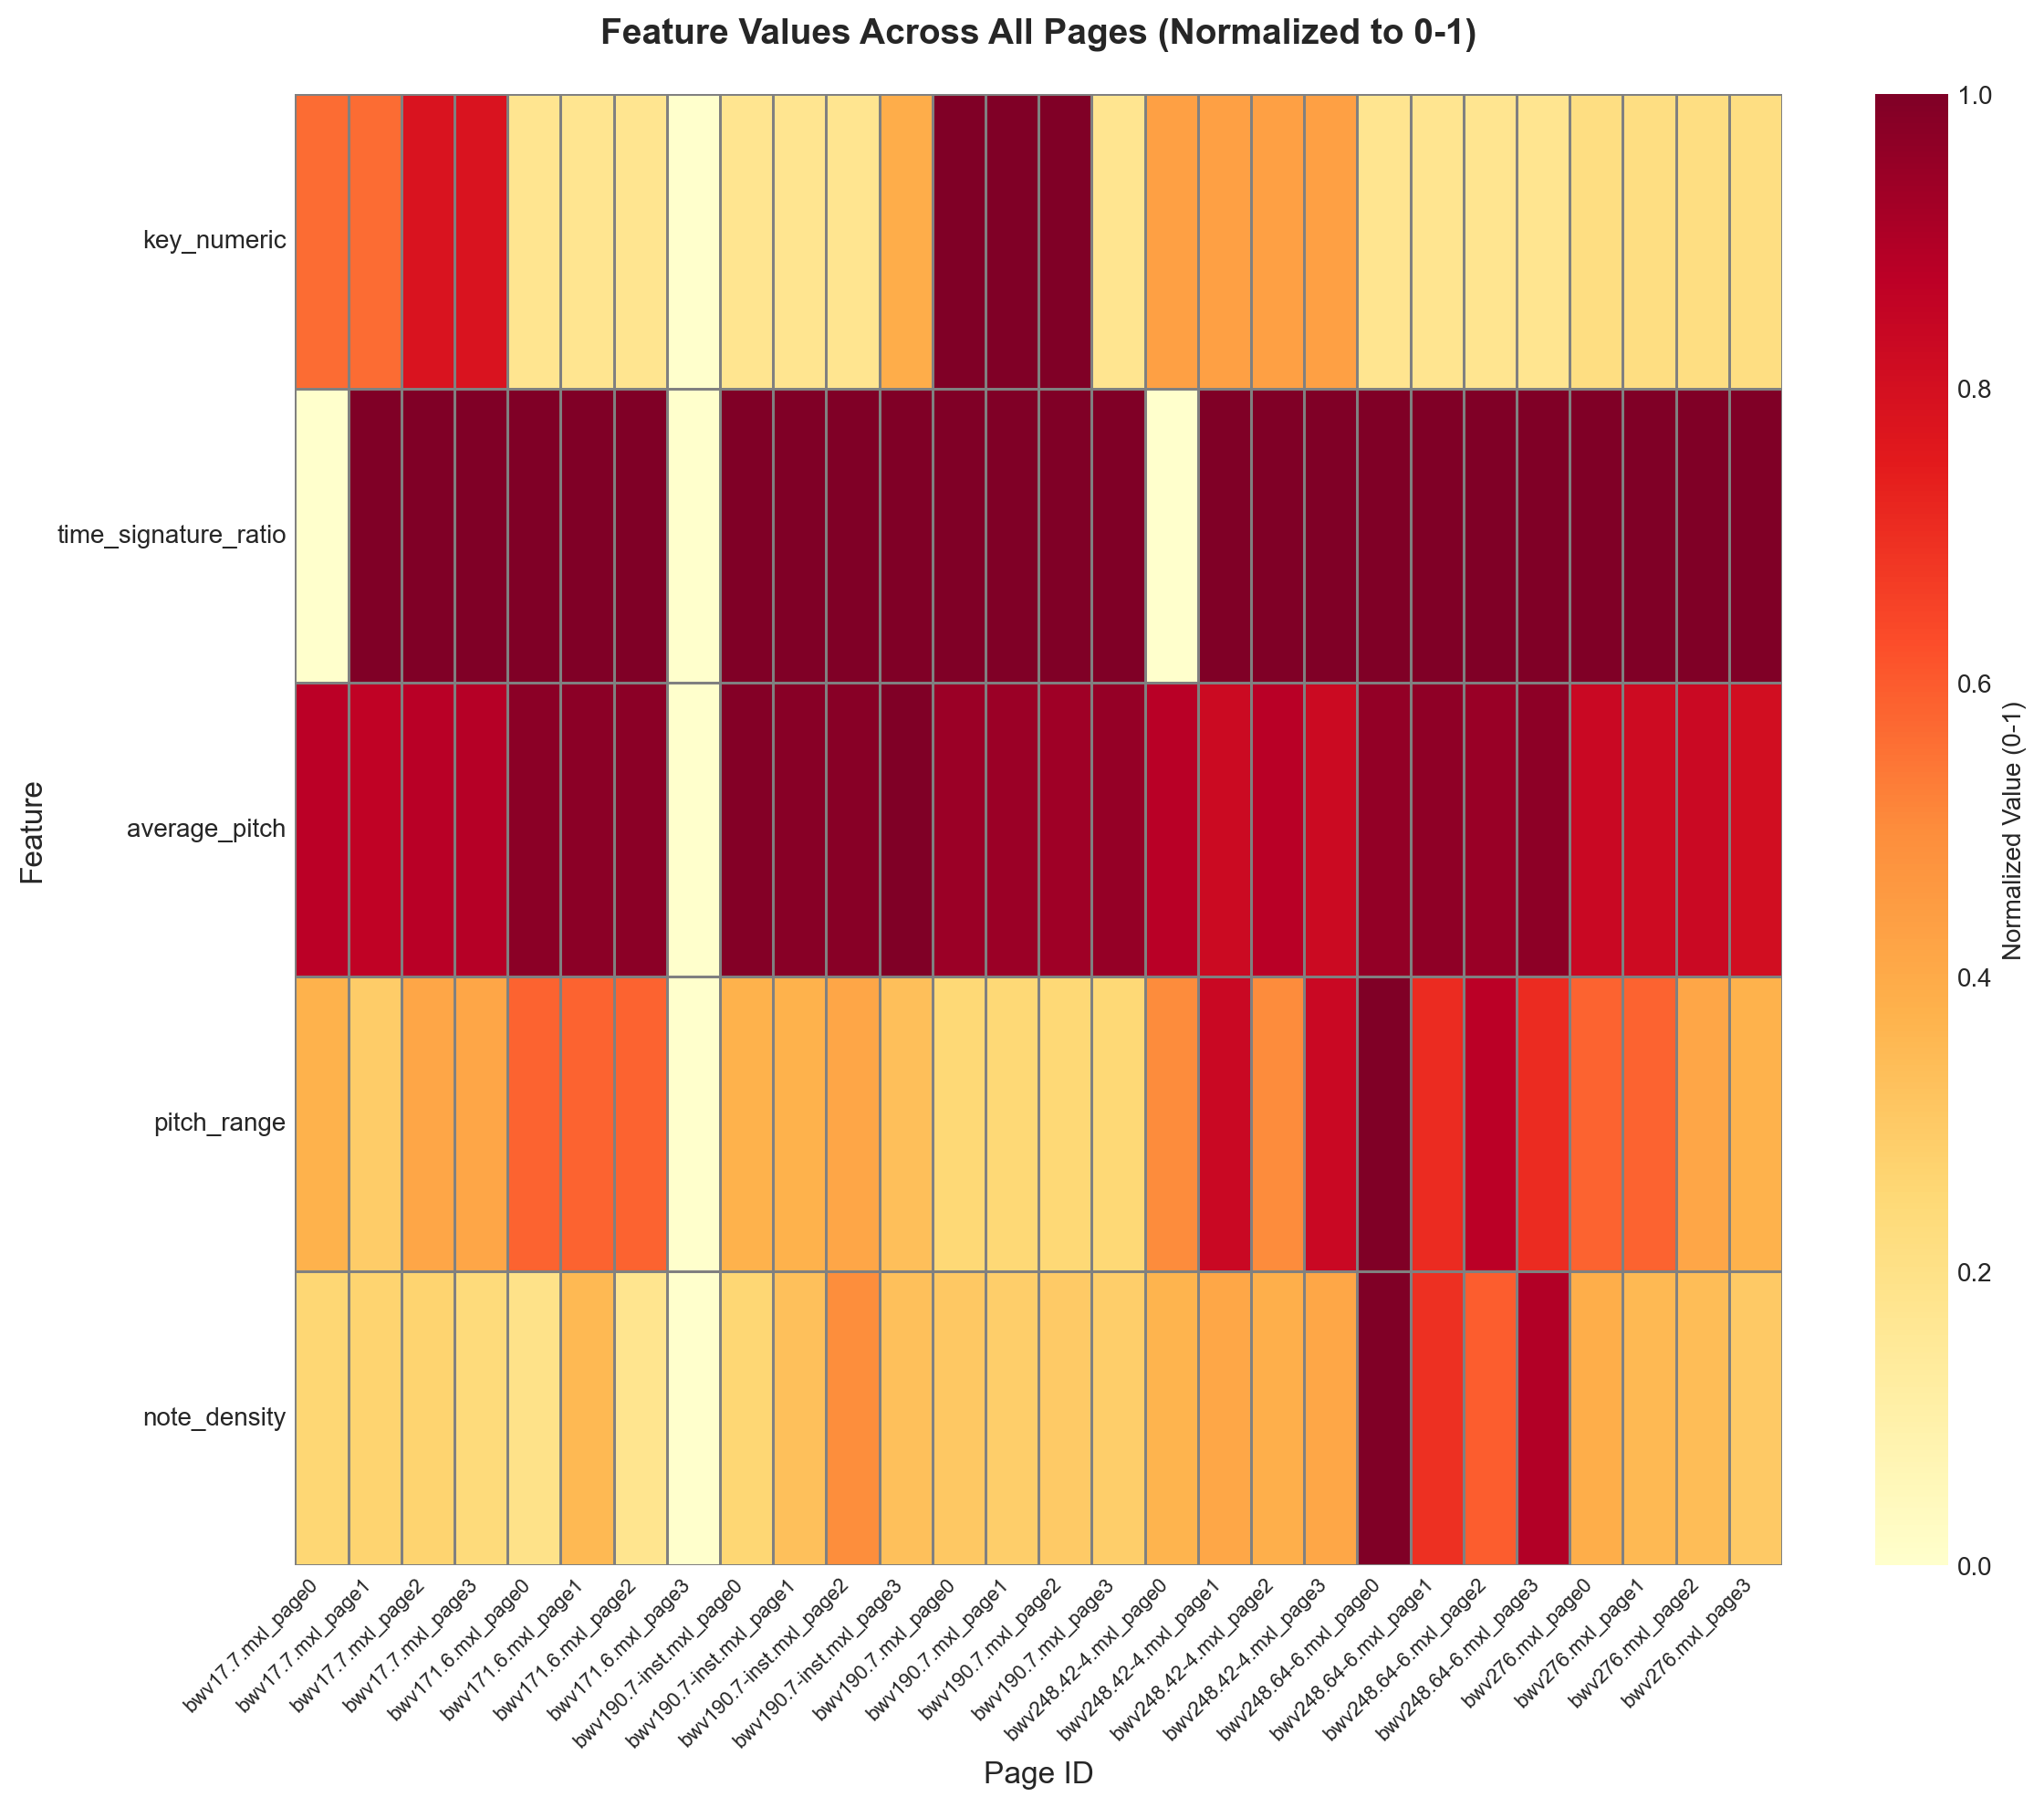

✓ Feature heatmap created

The heatmap shows normalized feature values (0-1 range) for 28 pages.
Warmer colors (red/orange) indicate higher values, cooler colors (yellow/white) indicate lower values.


In [16]:
# Normalize features to 0-1 range for visualization
from sklearn.preprocessing import MinMaxScaler

# Extract feature columns
feature_matrix = features_df[feature_cols].values

# Normalize each feature to 0-1 range
scaler = MinMaxScaler()
feature_matrix_normalized = scaler.fit_transform(feature_matrix)

# Create normalized DataFrame for visualization
features_normalized_df = pd.DataFrame(
    feature_matrix_normalized,
    columns=feature_cols,
    index=features_df['page_id']
)

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(
    features_normalized_df.T,  # Transpose so features are rows
    cmap='YlOrRd',
    cbar_kws={'label': 'Normalized Value (0-1)'},
    linewidths=0.5,
    linecolor='gray',
    ax=ax,
    vmin=0,
    vmax=1
)

ax.set_xlabel('Page ID', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Feature Values Across All Pages (Normalized to 0-1)', 
             fontsize=14, fontweight='bold', pad=20)

# Rotate x-axis labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

print("✓ Feature heatmap created")
print(f"\nThe heatmap shows normalized feature values (0-1 range) for {len(features_df)} pages.")
print("Warmer colors (red/orange) indicate higher values, cooler colors (yellow/white) indicate lower values.")


## Feature Similarity Functions

Define how to compute similarity between two pages for each feature. Each similarity function returns a value between 0 (completely different) and 1 (identical).

The similarity functions will be used to compare pages in the optimization-based matching algorithm.

In [17]:
def key_similarity(key1, key2):
    """
    Compute similarity between two key signatures.
    
    Args:
        key1, key2: Key numeric values (0-11.5)
        
    Returns:
        Similarity score between 0 and 1
        
    Formula: max(0, 1 - |key1 - key2| / 6)
    Normalizes by 6 (half octave) to capture key relationships.
    """
    return max(0.0, 1.0 - abs(key1 - key2) / 6.0)


def time_sig_similarity(ts1, ts2):
    """
    Compute similarity between two time signatures.
    
    Args:
        ts1, ts2: Time signature ratios (e.g., 0.75 for 3/4)
        
    Returns:
        1.0 if exact match, 0.0 otherwise
        
    Binary similarity - time signatures either match or don't.
    """
    return 1.0 if abs(ts1 - ts2) < 1e-6 else 0.0


def average_pitch_similarity(pitch1, pitch2):
    """
    Compute similarity between average pitches.
    
    Args:
        pitch1, pitch2: Average MIDI pitch values
        
    Returns:
        Similarity score between 0 and 1
        
    Formula: max(0, 1 - |pitch1 - pitch2| / 24)
    Normalizes by 24 semitones (2 octaves), a typical vocal range.
    """
    return max(0.0, 1.0 - abs(pitch1 - pitch2) / 24.0)


def pitch_range_similarity(range1, range2):
    """
    Compute similarity between pitch ranges.
    
    Args:
        range1, range2: Pitch range values (max - min pitch)
        
    Returns:
        Similarity score between 0 and 1
        
    Formula: max(0, 1 - |range1 - range2| / 24)
    Normalizes by 24 semitones (2 octaves).
    """
    return max(0.0, 1.0 - abs(range1 - range2) / 24.0)


def note_density_similarity(density1, density2):
    """
    Compute similarity between note densities.
    
    Args:
        density1, density2: Note density values (notes per beat)
        
    Returns:
        Similarity score between 0 and 1
        
    Formula: max(0, 1 - |density1 - density2| / 5)
    Normalizes by 5, a typical range for note density variations.
    """
    return max(0.0, 1.0 - abs(density1 - density2) / 5.0)


print("✓ Individual similarity functions defined:")
print("  - key_similarity()")
print("  - time_sig_similarity()")
print("  - average_pitch_similarity()")
print("  - pitch_range_similarity()")
print("  - note_density_similarity()")

✓ Individual similarity functions defined:
  - key_similarity()
  - time_sig_similarity()
  - average_pitch_similarity()
  - pitch_range_similarity()
  - note_density_similarity()


### Combined Similarity Function

Create a function that computes all 5 feature similarities between two pages and returns them as a vector.

In [18]:
def compute_similarity_vector(page_features_1, page_features_2):
    """
    Compute similarity vector between two pages across all features.
    
    Args:
        page_features_1: Series or dict with features for page 1
        page_features_2: Series or dict with features for page 2
        
    Returns:
        numpy array of shape (5,) with similarity values for:
        [key, time_sig, avg_pitch, pitch_range, note_density]
        
    Each similarity value is between 0 (completely different) and 1 (identical).
    """
    similarities = np.array([
        key_similarity(
            page_features_1['key_numeric'], 
            page_features_2['key_numeric']
        ),
        time_sig_similarity(
            page_features_1['time_signature_ratio'], 
            page_features_2['time_signature_ratio']
        ),
        average_pitch_similarity(
            page_features_1['average_pitch'], 
            page_features_2['average_pitch']
        ),
        pitch_range_similarity(
            page_features_1['pitch_range'], 
            page_features_2['pitch_range']
        ),
        note_density_similarity(
            page_features_1['note_density'], 
            page_features_2['note_density']
        )
    ])
    
    return similarities


print("✓ Combined similarity function defined: compute_similarity_vector()")
print("  Returns numpy array with 5 similarity values (0-1 range)")

✓ Combined similarity function defined: compute_similarity_vector()
  Returns numpy array with 5 similarity values (0-1 range)


### Test Similarity Functions

Test the similarity functions on sample page pairs to verify they work correctly:
1. **Within-chorale comparison**: Two pages from the same chorale (should have high similarities)
2. **Between-chorale comparison**: Two pages from different chorales (should have lower similarities)

In [19]:
print("Testing Similarity Functions")
print("=" * 80)

# Get list of unique chorale IDs
unique_chorales = features_df['chorale_id'].unique()
print(f"Available chorales: {list(unique_chorales)}\n")

# Test 1: Compare two pages from the SAME chorale
# Select first two pages from the first chorale
chorale_1_pages = features_df[features_df['chorale_id'] == unique_chorales[0]]
page1 = chorale_1_pages.iloc[0]
page2 = chorale_1_pages.iloc[1]

print("Test 1: Within-Chorale Similarity (Same Chorale)")
print("-" * 80)
print(f"Page 1: {page1['page_id']}")
print(f"Page 2: {page2['page_id']}")
print(f"Chorale: {page1['chorale_id']}")
print()

# Compute similarity
sim_within = compute_similarity_vector(page1, page2)

print("Feature values:")
print(f"  Page 1: key={page1['key_numeric']:.2f}, ts={page1['time_signature_ratio']:.2f}, "
      f"pitch={page1['average_pitch']:.2f}, range={page1['pitch_range']:.2f}, "
      f"density={page1['note_density']:.2f}")
print(f"  Page 2: key={page2['key_numeric']:.2f}, ts={page2['time_signature_ratio']:.2f}, "
      f"pitch={page2['average_pitch']:.2f}, range={page2['pitch_range']:.2f}, "
      f"density={page2['note_density']:.2f}")
print()

print("Similarity vector:")
feature_names = ['key', 'time_sig', 'avg_pitch', 'pitch_range', 'note_density']
for i, (name, sim_val) in enumerate(zip(feature_names, sim_within)):
    print(f"  {name:15s}: {sim_val:.3f}")
print(f"  {'Mean similarity':15s}: {sim_within.mean():.3f}")

print("\n" + "=" * 80)

# Test 2: Compare pages from DIFFERENT chorales
# Select first page from first chorale and first page from second chorale
if len(unique_chorales) >= 2:
    chorale_2_pages = features_df[features_df['chorale_id'] == unique_chorales[1]]
    page3 = chorale_1_pages.iloc[0]
    page4 = chorale_2_pages.iloc[0]
    
    print("\nTest 2: Between-Chorale Similarity (Different Chorales)")
    print("-" * 80)
    print(f"Page 3: {page3['page_id']} (Chorale: {page3['chorale_id']})")
    print(f"Page 4: {page4['page_id']} (Chorale: {page4['chorale_id']})")
    print()
    
    # Compute similarity
    sim_between = compute_similarity_vector(page3, page4)
    
    print("Feature values:")
    print(f"  Page 3: key={page3['key_numeric']:.2f}, ts={page3['time_signature_ratio']:.2f}, "
          f"pitch={page3['average_pitch']:.2f}, range={page3['pitch_range']:.2f}, "
          f"density={page3['note_density']:.2f}")
    print(f"  Page 4: key={page4['key_numeric']:.2f}, ts={page4['time_signature_ratio']:.2f}, "
          f"pitch={page4['average_pitch']:.2f}, range={page4['pitch_range']:.2f}, "
          f"density={page4['note_density']:.2f}")
    print()
    
    print("Similarity vector:")
    for i, (name, sim_val) in enumerate(zip(feature_names, sim_between)):
        print(f"  {name:15s}: {sim_val:.3f}")
    print(f"  {'Mean similarity':15s}: {sim_between.mean():.3f}")
    
    print("\n" + "=" * 80)
    print("\nComparison:")
    print(f"  Within-chorale mean similarity:  {sim_within.mean():.3f}")
    print(f"  Between-chorale mean similarity: {sim_between.mean():.3f}")
    print(f"  Difference: {sim_within.mean() - sim_between.mean():.3f}")
    
    if sim_within.mean() > sim_between.mean():
        print("  ✓ Expected behavior: Pages from same chorale are more similar")
    else:
        print("  ⚠ Unexpected: Between-chorale similarity is higher")
else:
    print("\n⚠ Not enough chorales to test between-chorale similarity")

print("\n" + "=" * 80)
print("✓ Similarity function testing complete!")

Testing Similarity Functions
Available chorales: ['bwv17.7.mxl', 'bwv171.6.mxl', 'bwv190.7-inst.mxl', 'bwv190.7.mxl', 'bwv248.42-4.mxl', 'bwv248.64-6.mxl', 'bwv276.mxl']

Test 1: Within-Chorale Similarity (Same Chorale)
--------------------------------------------------------------------------------
Page 1: bwv17.7.mxl_page0
Page 2: bwv17.7.mxl_page1
Chorale: bwv17.7.mxl

Feature values:
  Page 1: key=6.50, ts=0.75, pitch=70.19, range=9.00, density=0.73
  Page 2: key=6.50, ts=1.00, pitch=69.50, range=7.00, density=0.76

Similarity vector:
  key            : 1.000
  time_sig       : 0.000
  avg_pitch      : 0.971
  pitch_range    : 0.917
  note_density   : 0.993
  Mean similarity: 0.776


Test 2: Between-Chorale Similarity (Different Chorales)
--------------------------------------------------------------------------------
Page 3: bwv17.7.mxl_page0 (Chorale: bwv17.7.mxl)
Page 4: bwv171.6.mxl_page0 (Chorale: bwv171.6.mxl)

Feature values:
  Page 3: key=6.50, ts=0.75, pitch=70.19, range=9

## Generate Training Pairs with Ground Truth Labels

Create a dataset of page pairs with labels for training and testing the optimization algorithm:
- **Matching pairs (label=1)**: Pages from the same chorale
- **Non-matching pairs (label=0)**: Pages from different chorales

Each pair will have a computed similarity vector across all 5 features.

In [20]:
# Set random seed for reproducibility
np.random.seed(42)

print("Generating Training Pairs")
print("=" * 80)

# Configuration
NUM_MATCHING_PAIRS = 10
NUM_NON_MATCHING_PAIRS = 10

# ===== Generate Matching Pairs (label = 1) =====
print(f"\nStep 1: Generating {NUM_MATCHING_PAIRS} matching pairs (same chorale)")
print("-" * 80)

matching_pairs = []
unique_chorales = features_df['chorale_id'].unique()

# Calculate how many pairs per chorale (approximately)
pairs_per_chorale = NUM_MATCHING_PAIRS // len(unique_chorales)
extra_pairs = NUM_MATCHING_PAIRS % len(unique_chorales)

for i, chorale_id in enumerate(unique_chorales):
    # Get all pages for this chorale
    chorale_pages = features_df[features_df['chorale_id'] == chorale_id]
    page_indices = chorale_pages.index.tolist()
    
    # Determine number of pairs for this chorale
    num_pairs_this_chorale = pairs_per_chorale + (1 if i < extra_pairs else 0)
    
    if len(page_indices) < 2:
        print(f"  ⚠ {chorale_id}: Only {len(page_indices)} pages, skipping")
        continue
    
    # Generate diverse pairs (not just consecutive)
    # Get all possible pairs
    from itertools import combinations
    all_possible_pairs = list(combinations(page_indices, 2))
    
    # Sample randomly from possible pairs
    num_pairs_to_sample = min(num_pairs_this_chorale, len(all_possible_pairs))
    sampled_pairs = np.random.choice(len(all_possible_pairs), size=num_pairs_to_sample, replace=False)
    
    for pair_idx in sampled_pairs:
        idx1, idx2 = all_possible_pairs[pair_idx]
        matching_pairs.append((idx1, idx2))
    
    print(f"  ✓ {chorale_id}: Generated {num_pairs_to_sample} pairs from {len(page_indices)} pages")

print(f"\n✓ Generated {len(matching_pairs)} matching pairs")

# ===== Generate Non-Matching Pairs (label = 0) =====
print(f"\nStep 2: Generating {NUM_NON_MATCHING_PAIRS} non-matching pairs (different chorales)")
print("-" * 80)

non_matching_pairs = []

# Generate pairs from different chorales
for _ in range(NUM_NON_MATCHING_PAIRS):
    # Select two different chorales
    chorale_ids = np.random.choice(unique_chorales, size=2, replace=False)
    
    # Select random page from each chorale
    page1_idx = features_df[features_df['chorale_id'] == chorale_ids[0]].sample(1).index[0]
    page2_idx = features_df[features_df['chorale_id'] == chorale_ids[1]].sample(1).index[0]
    
    non_matching_pairs.append((page1_idx, page2_idx))

# Count chorales involved
chorale_counts = {}
for idx1, idx2 in non_matching_pairs:
    c1 = features_df.loc[idx1, 'chorale_id']
    c2 = features_df.loc[idx2, 'chorale_id']
    chorale_counts[c1] = chorale_counts.get(c1, 0) + 1
    chorale_counts[c2] = chorale_counts.get(c2, 0) + 1

print(f"✓ Generated {len(non_matching_pairs)} non-matching pairs")
print(f"  Chorales involved: {len(chorale_counts)} different chorales")
for chorale_id, count in sorted(chorale_counts.items()):
    print(f"    {chorale_id}: {count} pairs")

print("\n" + "=" * 80)
print(f"Total pairs generated: {len(matching_pairs) + len(non_matching_pairs)}")


Generating Training Pairs

Step 1: Generating 10 matching pairs (same chorale)
--------------------------------------------------------------------------------
  ✓ bwv17.7.mxl: Generated 2 pairs from 4 pages
  ✓ bwv171.6.mxl: Generated 2 pairs from 4 pages
  ✓ bwv190.7-inst.mxl: Generated 2 pairs from 4 pages
  ✓ bwv190.7.mxl: Generated 1 pairs from 4 pages
  ✓ bwv248.42-4.mxl: Generated 1 pairs from 4 pages
  ✓ bwv248.64-6.mxl: Generated 1 pairs from 4 pages
  ✓ bwv276.mxl: Generated 1 pairs from 4 pages

✓ Generated 10 matching pairs

Step 2: Generating 10 non-matching pairs (different chorales)
--------------------------------------------------------------------------------
✓ Generated 10 non-matching pairs
  Chorales involved: 6 different chorales
    bwv17.7.mxl: 5 pairs
    bwv171.6.mxl: 4 pairs
    bwv190.7-inst.mxl: 5 pairs
    bwv248.42-4.mxl: 1 pairs
    bwv248.64-6.mxl: 2 pairs
    bwv276.mxl: 3 pairs

Total pairs generated: 20


### Compute Similarity Vectors for All Pairs

For each pair, compute the 5-dimensional similarity vector using the previously defined functions.

In [21]:
print("Computing similarity vectors for all pairs...")
print("=" * 80)

# Prepare data for DataFrame
dataset_rows = []

# Process matching pairs (label = 1)
print(f"\nProcessing {len(matching_pairs)} matching pairs...")
for idx1, idx2 in matching_pairs:
    page1 = features_df.loc[idx1]
    page2 = features_df.loc[idx2]
    
    # Compute similarity vector
    sim_vector = compute_similarity_vector(page1, page2)
    
    # Create row for dataset
    row = {
        'page_id_1': page1['page_id'],
        'page_id_2': page2['page_id'],
        'chorale_1': page1['chorale_id'],
        'chorale_2': page2['chorale_id'],
        'label': 1,  # Matching pair
        'sim_key': sim_vector[0],
        'sim_time_sig': sim_vector[1],
        'sim_avg_pitch': sim_vector[2],
        'sim_pitch_range': sim_vector[3],
        'sim_note_density': sim_vector[4]
    }
    dataset_rows.append(row)

print(f"✓ Processed {len(matching_pairs)} matching pairs")

# Process non-matching pairs (label = 0)
print(f"\nProcessing {len(non_matching_pairs)} non-matching pairs...")
for idx1, idx2 in non_matching_pairs:
    page1 = features_df.loc[idx1]
    page2 = features_df.loc[idx2]
    
    # Compute similarity vector
    sim_vector = compute_similarity_vector(page1, page2)
    
    # Create row for dataset
    row = {
        'page_id_1': page1['page_id'],
        'page_id_2': page2['page_id'],
        'chorale_1': page1['chorale_id'],
        'chorale_2': page2['chorale_id'],
        'label': 0,  # Non-matching pair
        'sim_key': sim_vector[0],
        'sim_time_sig': sim_vector[1],
        'sim_avg_pitch': sim_vector[2],
        'sim_pitch_range': sim_vector[3],
        'sim_note_density': sim_vector[4]
    }
    dataset_rows.append(row)

print(f"✓ Processed {len(non_matching_pairs)} non-matching pairs")

# Create DataFrame
pairs_dataset = pd.DataFrame(dataset_rows)

print("\n" + "=" * 80)
print(f"Dataset created: {len(pairs_dataset)} total pairs")
print(f"  Matching pairs (label=1): {(pairs_dataset['label'] == 1).sum()}")
print(f"  Non-matching pairs (label=0): {(pairs_dataset['label'] == 0).sum()}")
print(f"\nDataset shape: {pairs_dataset.shape}")
print(f"Columns: {list(pairs_dataset.columns)}")


Computing similarity vectors for all pairs...

Processing 10 matching pairs...
✓ Processed 10 matching pairs

Processing 10 non-matching pairs...
✓ Processed 10 non-matching pairs

Dataset created: 20 total pairs
  Matching pairs (label=1): 10
  Non-matching pairs (label=0): 10

Dataset shape: (20, 10)
Columns: ['page_id_1', 'page_id_2', 'chorale_1', 'chorale_2', 'label', 'sim_key', 'sim_time_sig', 'sim_avg_pitch', 'sim_pitch_range', 'sim_note_density']


### Train/Test Split

Split the dataset into training (70%) and testing (30%) sets, ensuring both splits have both matching and non-matching pairs.

In [22]:
from sklearn.model_selection import train_test_split

print("Creating Train/Test Split")
print("=" * 80)

# Configuration
TEST_SIZE = 0.3  # 30% for testing
RANDOM_STATE = 42

# Perform stratified split to ensure both labels are in both splits
train_data, test_data = train_test_split(
    pairs_dataset,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=pairs_dataset['label']  # Stratify by label to ensure balanced splits
)

print(f"\nSplit configuration:")
print(f"  Test size: {TEST_SIZE * 100:.0f}%")
print(f"  Random state: {RANDOM_STATE}")

print(f"\nTraining set:")
print(f"  Total pairs: {len(train_data)}")
print(f"  Matching pairs (label=1): {(train_data['label'] == 1).sum()}")
print(f"  Non-matching pairs (label=0): {(train_data['label'] == 0).sum()}")
print(f"  Balance: {(train_data['label'] == 1).sum() / len(train_data) * 100:.1f}% positive")

print(f"\nTest set:")
print(f"  Total pairs: {len(test_data)}")
print(f"  Matching pairs (label=1): {(test_data['label'] == 1).sum()}")
print(f"  Non-matching pairs (label=0): {(test_data['label'] == 0).sum()}")
print(f"  Balance: {(test_data['label'] == 1).sum() / len(test_data) * 100:.1f}% positive")

print("\n" + "=" * 80)
print("✓ Train/test split complete!")


Creating Train/Test Split

Split configuration:
  Test size: 30%
  Random state: 42

Training set:
  Total pairs: 14
  Matching pairs (label=1): 7
  Non-matching pairs (label=0): 7
  Balance: 50.0% positive

Test set:
  Total pairs: 6
  Matching pairs (label=1): 3
  Non-matching pairs (label=0): 3
  Balance: 50.0% positive

✓ Train/test split complete!


### Dataset Visualization and Analysis

Visualize sample pairs and analyze feature correlations.

In [23]:
print("Sample Pairs from Training Set")
print("=" * 80)

# Show 5 sample pairs (mix of matching and non-matching)
# Get 3 matching and 2 non-matching
matching_samples = train_data[train_data['label'] == 1].head(3)
non_matching_samples = train_data[train_data['label'] == 0].head(2)
sample_pairs = pd.concat([matching_samples, non_matching_samples])

# Define feature columns for display
sim_cols = ['sim_key', 'sim_time_sig', 'sim_avg_pitch', 'sim_pitch_range', 'sim_note_density']

print("\nShowing 5 sample pairs (3 matching, 2 non-matching):\n")

for idx, row in sample_pairs.iterrows():
    label_str = "MATCH" if row['label'] == 1 else "NON-MATCH"
    print(f"Pair: {row['page_id_1']} <-> {row['page_id_2']}")
    print(f"  Label: {label_str}")
    print(f"  Chorales: {row['chorale_1']} <-> {row['chorale_2']}")
    print(f"  Similarity vector:")
    for col in sim_cols:
        print(f"    {col:20s}: {row[col]:.3f}")
    print()

print("=" * 80)


Sample Pairs from Training Set

Showing 5 sample pairs (3 matching, 2 non-matching):

Pair: bwv190.7-inst.mxl_page0 <-> bwv190.7-inst.mxl_page2
  Label: MATCH
  Chorales: bwv190.7-inst.mxl <-> bwv190.7-inst.mxl
  Similarity vector:
    sim_key             : 1.000
    sim_time_sig        : 1.000
    sim_avg_pitch       : 0.974
    sim_pitch_range     : 0.958
    sim_note_density    : 0.864

Pair: bwv171.6.mxl_page0 <-> bwv171.6.mxl_page1
  Label: MATCH
  Chorales: bwv171.6.mxl <-> bwv171.6.mxl
  Similarity vector:
    sim_key             : 1.000
    sim_time_sig        : 1.000
    sim_avg_pitch       : 1.000
    sim_pitch_range     : 1.000
    sim_note_density    : 0.910

Pair: bwv17.7.mxl_page0 <-> bwv17.7.mxl_page2
  Label: MATCH
  Chorales: bwv17.7.mxl <-> bwv17.7.mxl
  Similarity vector:
    sim_key             : 0.583
    sim_time_sig        : 0.000
    sim_avg_pitch       : 0.987
    sim_pitch_range     : 0.958
    sim_note_density    : 0.993

Pair: bwv190.7-inst.mxl_page3 <-> bwv


Feature Correlation Analysis

Correlation Matrix:
                   sim_key  sim_time_sig  sim_avg_pitch  sim_pitch_range  sim_note_density
sim_key           1.000000     -0.063110       0.336906         0.110763         -0.155130
sim_time_sig     -0.063110      1.000000       0.290605         0.350063          0.117243
sim_avg_pitch     0.336906      0.290605       1.000000         0.629063          0.595641
sim_pitch_range   0.110763      0.350063       0.629063         1.000000          0.682815
sim_note_density -0.155130      0.117243       0.595641         0.682815          1.000000

Interpretation:
  Values close to 1 or -1 indicate high correlation (redundant features)
  Values close to 0 indicate low correlation (independent features)


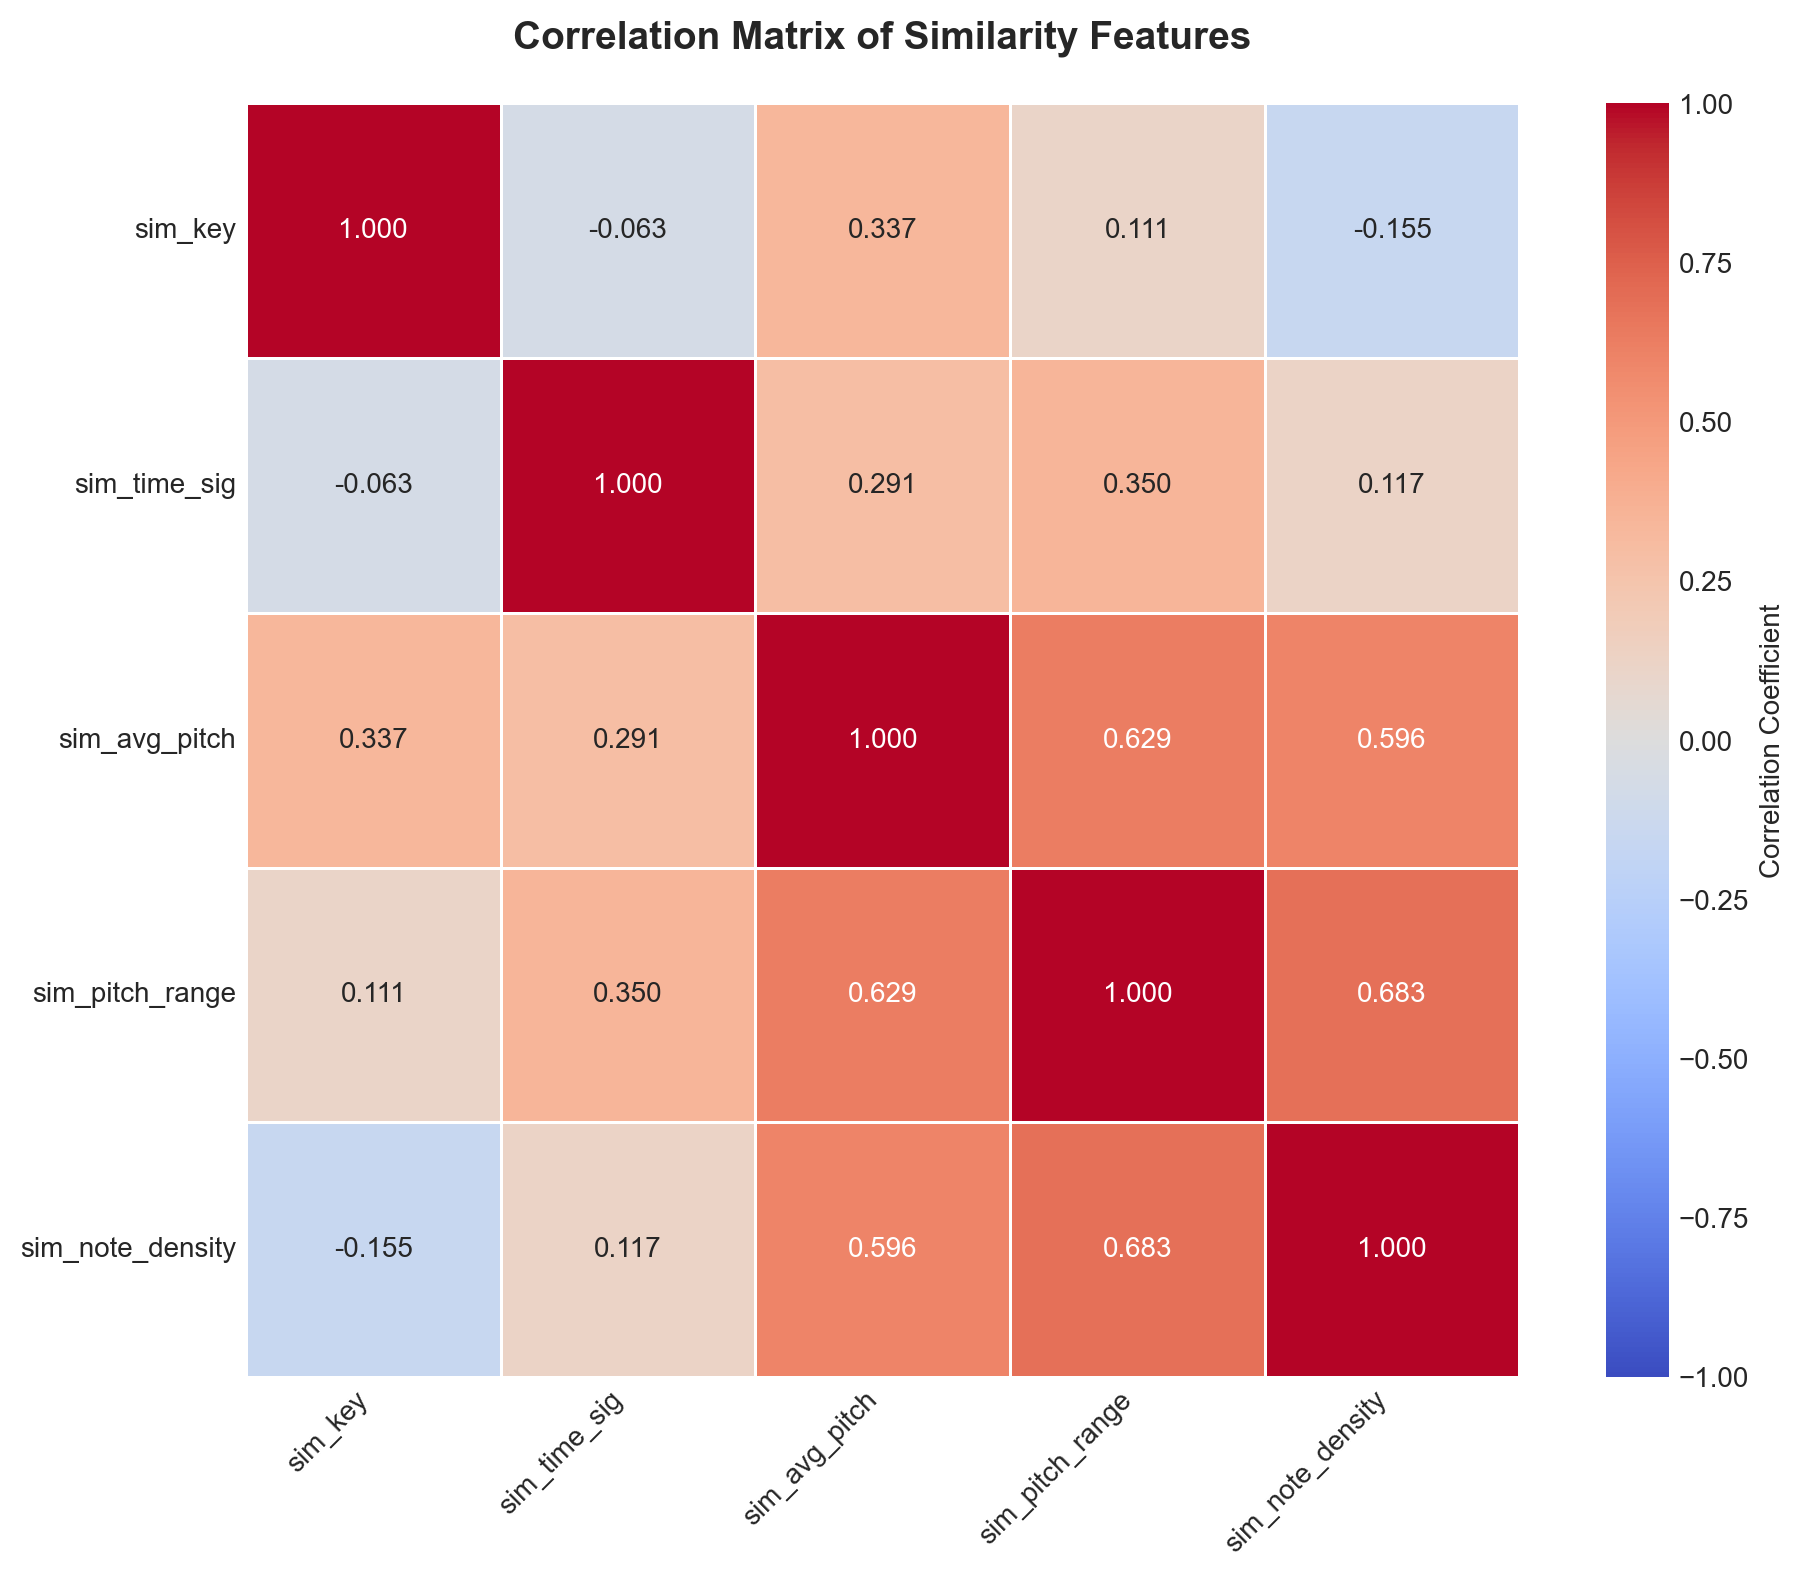


✓ Feature correlation analysis complete!


In [24]:
print("\nFeature Correlation Analysis")
print("=" * 80)

# Extract similarity features
sim_features = pairs_dataset[sim_cols]

# Compute correlation matrix
correlation_matrix = sim_features.corr()

print("\nCorrelation Matrix:")
print(correlation_matrix.to_string())

print("\n" + "=" * 80)
print("Interpretation:")
print("  Values close to 1 or -1 indicate high correlation (redundant features)")
print("  Values close to 0 indicate low correlation (independent features)")

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=1,
    cbar_kws={'label': 'Correlation Coefficient'},
    ax=ax
)

ax.set_title('Correlation Matrix of Similarity Features', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print("\n✓ Feature correlation analysis complete!")


### Summary Statistics

Display summary statistics for similarity features grouped by label.

In [26]:
print("Summary Statistics by Label")
print("=" * 80)

# Group by label and compute statistics
print("\nMatching Pairs (label=1):")
print("-" * 80)
matching_stats = pairs_dataset[pairs_dataset['label'] == 1][sim_cols].describe()
print(matching_stats.to_string())

print("\n\nNon-Matching Pairs (label=0):")
print("-" * 80)
non_matching_stats = pairs_dataset[pairs_dataset['label'] == 0][sim_cols].describe()
print(non_matching_stats.to_string())

print("\n\nMean Differences (Matching - Non-Matching):")
print("-" * 80)
mean_matching = pairs_dataset[pairs_dataset['label'] == 1][sim_cols].mean()
mean_non_matching = pairs_dataset[pairs_dataset['label'] == 0][sim_cols].mean()
mean_diff = mean_matching - mean_non_matching

for col in sim_cols:
    print(f"  {col:20s}: {mean_diff[col]:+.3f}")
    if mean_diff[col] > 0:
        print(f"    → Matching pairs have higher {col.replace('sim_', '')} similarity")
    else:
        print(f"    → Non-matching pairs have higher {col.replace('sim_', '')} similarity")

print("\n" + "=" * 80)
print("✓ Dataset preparation complete!")
print(f"\nFinal dataset summary:")
print(f"  Total pairs: {len(pairs_dataset)}")
print(f"  Training pairs: {len(train_data)} (70%)")
print(f"  Testing pairs: {len(test_data)} (30%)")
print(f"  Features per pair: {len(sim_cols)}")


Summary Statistics by Label

Matching Pairs (label=1):
--------------------------------------------------------------------------------
         sim_key  sim_time_sig  sim_avg_pitch  sim_pitch_range  sim_note_density
count  10.000000     10.000000      10.000000        10.000000         10.000000
mean    0.916667      0.700000       0.956889         0.929167          0.943572
std     0.175682      0.483046       0.056958         0.105866          0.061942
min     0.583333      0.000000       0.813571         0.666667          0.831250
25%     1.000000      0.250000       0.950260         0.927083          0.902586
50%     1.000000      1.000000       0.972913         0.958333          0.977155
75%     1.000000      1.000000       0.994870         1.000000          0.992327
max     1.000000      1.000000       1.000000         1.000000          1.000000


Non-Matching Pairs (label=0):
--------------------------------------------------------------------------------
         sim_key  sim_

## Save Processed Data for Optimization Notebook

Save all processed data to files for use in the next notebook (optimization and weight learning).

In [27]:
import json
import os
from pathlib import Path

print("Saving Processed Data")
print("=" * 80)

# Create data directory if it doesn't exist
data_dir = Path('../data')
data_dir.mkdir(exist_ok=True)

# Define file paths
features_file = data_dir / 'sheet_music_features.csv'
train_file = data_dir / 'train_pairs.csv'
test_file = data_dir / 'test_pairs.csv'
metadata_file = data_dir / 'data_metadata.json'

# ===== 1. Save Features DataFrame =====
print("\n1. Saving features DataFrame...")
features_df.to_csv(features_file, index=False)
print(f"   ✓ Saved to: {features_file}")
print(f"   Size: {os.path.getsize(features_file) / 1024:.2f} KB")
print(f"   Rows: {len(features_df)}, Columns: {len(features_df.columns)}")

# ===== 2. Save Training Pairs =====
print("\n2. Saving training pairs...")
train_data.to_csv(train_file, index=False)
print(f"   ✓ Saved to: {train_file}")
print(f"   Size: {os.path.getsize(train_file) / 1024:.2f} KB")
print(f"   Rows: {len(train_data)}, Columns: {len(train_data.columns)}")

# ===== 3. Save Test Pairs =====
print("\n3. Saving test pairs...")
test_data.to_csv(test_file, index=False)
print(f"   ✓ Saved to: {test_file}")
print(f"   Size: {os.path.getsize(test_file) / 1024:.2f} KB")
print(f"   Rows: {len(test_data)}, Columns: {len(test_data.columns)}")

# ===== 4. Save Metadata =====
print("\n4. Saving metadata...")

metadata = {
    'dataset_info': {
        'total_chorales': len(chorales_data),
        'total_pages': len(pages_df),
        'measures_per_page': MEASURES_PER_PAGE,
        'pages_per_chorale': TARGET_PAGES_PER_CHORALE,
        'chorale_ids': list(chorales_data.keys())
    },
    'features': {
        'count': len(feature_cols),
        'names': feature_cols,
        'description': {
            'key_numeric': 'Key signature (0-11 pitch class, +0.5 for minor)',
            'time_signature_ratio': 'Time signature as decimal (e.g., 3/4 = 0.75)',
            'average_pitch': 'Mean MIDI pitch number',
            'pitch_range': 'Range of pitches (max - min) in semitones',
            'note_density': 'Notes per beat (rhythmic activity)'
        }
    },
    'similarity_features': {
        'count': len(sim_cols),
        'names': sim_cols,
        'range': [0.0, 1.0],
        'description': '0 = completely different, 1 = identical'
    },
    'pairs': {
        'total_pairs': len(pairs_dataset),
        'matching_pairs': int((pairs_dataset['label'] == 1).sum()),
        'non_matching_pairs': int((pairs_dataset['label'] == 0).sum())
    },
    'train_test_split': {
        'test_size': TEST_SIZE,
        'random_state': RANDOM_STATE,
        'train_pairs': len(train_data),
        'test_pairs': len(test_data),
        'train_positive': int((train_data['label'] == 1).sum()),
        'train_negative': int((train_data['label'] == 0).sum()),
        'test_positive': int((test_data['label'] == 1).sum()),
        'test_negative': int((test_data['label'] == 0).sum())
    },
    'statistics': {
        'feature_stats': {
            col: {
                'mean': float(features_df[col].mean()),
                'std': float(features_df[col].std()),
                'min': float(features_df[col].min()),
                'max': float(features_df[col].max())
            }
            for col in feature_cols
        },
        'similarity_stats': {
            'matching': {
                col: float(pairs_dataset[pairs_dataset['label'] == 1][col].mean())
                for col in sim_cols
            },
            'non_matching': {
                col: float(pairs_dataset[pairs_dataset['label'] == 0][col].mean())
                for col in sim_cols
            }
        }
    }
}

with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"   ✓ Saved to: {metadata_file}")
print(f"   Size: {os.path.getsize(metadata_file) / 1024:.2f} KB")

print("\n" + "=" * 80)
print("✓ All data saved successfully!")
print(f"\nSaved files:")
print(f"  • {features_file.name} - Feature data for all pages")
print(f"  • {train_file.name} - Training pairs with similarity vectors")
print(f"  • {test_file.name} - Test pairs with similarity vectors")
print(f"  • {metadata_file.name} - Dataset metadata and statistics")


Saving Processed Data

1. Saving features DataFrame...
   ✓ Saved to: ../data/sheet_music_features.csv
   Size: 2.08 KB
   Rows: 28, Columns: 7

2. Saving training pairs...
   ✓ Saved to: ../data/train_pairs.csv
   Size: 1.94 KB
   Rows: 14, Columns: 10

3. Saving test pairs...
   ✓ Saved to: ../data/test_pairs.csv
   Size: 0.80 KB
   Rows: 6, Columns: 10

4. Saving metadata...
   ✓ Saved to: ../data/data_metadata.json
   Size: 2.69 KB

✓ All data saved successfully!

Saved files:
  • sheet_music_features.csv - Feature data for all pages
  • train_pairs.csv - Training pairs with similarity vectors
  • test_pairs.csv - Test pairs with similarity vectors
  • data_metadata.json - Dataset metadata and statistics


### Data Files Summary

This notebook has created and saved the following data files for use in the optimization notebook:

#### 1. `sheet_music_features.csv`
Contains extracted musical features for all pages in the dataset.

**Schema:**
- `page_id` (string): Unique identifier for each page (e.g., "bwv66.6_page0")
- `chorale_id` (string): Identifier of the source chorale
- `key_numeric` (float): Key signature encoded as 0-11.5 (pitch class + 0.5 for minor)
- `time_signature_ratio` (float): Time signature as decimal (e.g., 0.75 for 3/4)
- `average_pitch` (float): Mean MIDI pitch number
- `pitch_range` (float): Range of pitches in semitones
- `note_density` (float): Notes per beat

**Usage in next notebook:**
```python
features_df = pd.read_csv('../data/sheet_music_features.csv')
```

---

#### 2. `train_pairs.csv`
Training pairs with computed similarity vectors and ground truth labels.

**Schema:**
- `page_id_1`, `page_id_2` (string): Page identifiers for the pair
- `chorale_1`, `chorale_2` (string): Source chorale identifiers
- `label` (int): 1 = matching (same chorale), 0 = non-matching (different chorales)
- `sim_key` (float): Key similarity (0-1)
- `sim_time_sig` (float): Time signature similarity (0-1)
- `sim_avg_pitch` (float): Average pitch similarity (0-1)
- `sim_pitch_range` (float): Pitch range similarity (0-1)
- `sim_note_density` (float): Note density similarity (0-1)

**Usage in next notebook:**
```python
train_data = pd.read_csv('../data/train_pairs.csv')
X_train = train_data[['sim_key', 'sim_time_sig', 'sim_avg_pitch', 'sim_pitch_range', 'sim_note_density']].values
y_train = train_data['label'].values
```

---

#### 3. `test_pairs.csv`
Test pairs with computed similarity vectors and ground truth labels (same schema as `train_pairs.csv`).

**Usage in next notebook:**
```python
test_data = pd.read_csv('../data/test_pairs.csv')
X_test = test_data[['sim_key', 'sim_time_sig', 'sim_avg_pitch', 'sim_pitch_range', 'sim_note_density']].values
y_test = test_data['label'].values
```

---

#### 4. `data_metadata.json`
Comprehensive metadata including dataset statistics, feature descriptions, and split information.

**Usage in next notebook:**
```python
import json
with open('../data/data_metadata.json', 'r') as f:
    metadata = json.load(f)
print(f"Total chorales: {metadata['dataset_info']['total_chorales']}")
print(f"Total pages: {metadata['dataset_info']['total_pages']}")
```

---

### Next Steps

Proceed to **Notebook 2: Optimization and Weight Learning** where you will:
1. Load the processed data files
2. Define a weighted similarity function
3. Use cvxpy to learn optimal feature weights through constrained optimization
4. Evaluate performance on the test set
5. Visualize learned weights and matching performance